In [320]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro, levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency
import seaborn
#import scipy.stats as stats
import scipy.stats as stats
from scipy.stats import shapiro, poisson, chisquare, expon, kstest
# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv('../data/hr_raw_data_definitivo.csv', index_col=0)
df.head()

In [ ]:
# Nuestro grupo control estará formado por empleados que están satisfechos (puntuación mayor de 3).

grupo_control = df[df['satisfaction'] == 'satisfied']

In [ ]:
# Nuestro grupo variante estará formado por empleados que no están satisfechos (puntuación menor de 3).

grupo_variante = df[df['satisfaction'] == 'not satisfied']

In [ ]:
# Miramos % de rotación de empleados satisfechos.

grupo_control_porcentaje_rotacion = grupo_control[grupo_control['attrition'] == 'Yes']["employee_number"].count()/grupo_control.shape[0]*100
print(grupo_control_porcentaje_rotacion)

13.668341708542714


In [ ]:
# Miramos % de rotación de empleados no satisfechos. 

grupo_variante_porcentaje_rotacion = grupo_variante[grupo_variante['attrition'] == 'Yes']["employee_number"].count()/grupo_variante.shape[0]*100
print(grupo_variante_porcentaje_rotacion)

19.87075928917609


    H0 = No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.
    H1 = Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.

In [ ]:
'''Hacemos una tabla de contingencia para ver las proporciones, ya que son dos variables categóricas.'''
tabla_contingencia = pd.crosstab(df["satisfaction"], df["attrition"])

In [327]:
tabla_contingencia

attrition,No,Yes
satisfaction,,
not satisfied,496,123
satisfied,859,136


Hacemos una visualización del nivel de satisfacción y la rotación.

In [328]:
colores = ["#FF007F", "#FF4D6A", "#FF1C45", "#FF0000", "#E50000"]

/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/3749599741.py:2: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  plot = sns.countplot(x="satisfaction", data=df, hue='attrition', palette=colores)


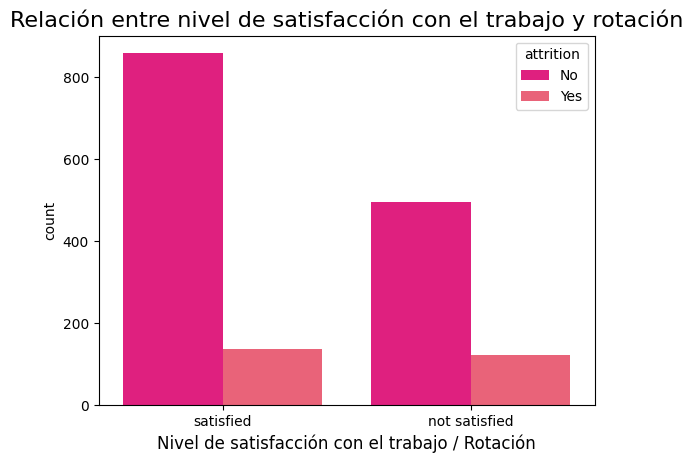

In [443]:
# Crear el gráfico de barras
plot = sns.countplot(x="satisfaction", data=df, hue='attrition', palette=colores)

# Títulos y etiquetas
plot.set_title("Relación entre nivel de satisfacción con el trabajo y rotación", fontsize=16)
plot.set_xlabel("Nivel de satisfacción con el trabajo / Rotación", fontsize=12)

# Mostrar el gráfico
plt.show()


In [330]:
'''Confirmar si nos quedamos con la H0 o la H1. En este caso calculamos el chi2 al tratarse de variables categóricas (proporciones).'''

_, p_value, _, _ = chi2_contingency(tabla_contingencia)
if p_value <= 0.05:
    print('Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')
else:
    print('No existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.')

Existe una relación entre el nivel de satisfacción en el trabajo y la rotación de empleados en la empresa.


Rechazamos H0 y nos quedamos con la H1 - Existe una relación significativa entre el nivel de satisfacción y la rotación. 

### ¿Existe relación entre el salario y el nivel de rotación de los empleados?
    H0 = No existe relación entre el salario y el nivel de rotación de os empleados.
    H1 = Existe relación entre el salario y el nivel de rotación de os empleados.

In [ ]:
grupo_control_rotacion = df[df['attrition'] == 'No'] # No se han ido de la empresa.

In [ ]:
grupo_variante_rotacion = df[df['attrition'] == 'Yes'] # Se han ido de la empresa.

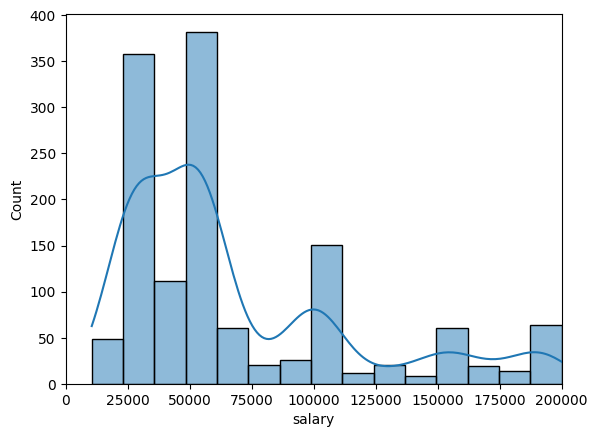

In [ ]:
'''Visualización distribución salarios de empleados que no se han ido de la empresa.'''
sns.histplot(x= 'salary', data= grupo_control_rotacion, kde=True)
plt.xlim(0, 200000); 

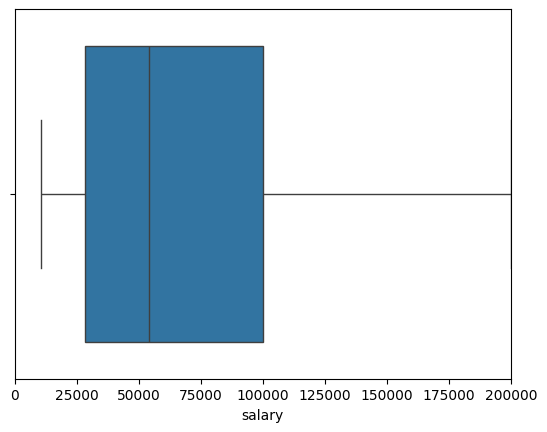

In [334]:
sns.boxplot(x= 'salary', data= grupo_control_rotacion)
plt.xlim(0, 200000); 

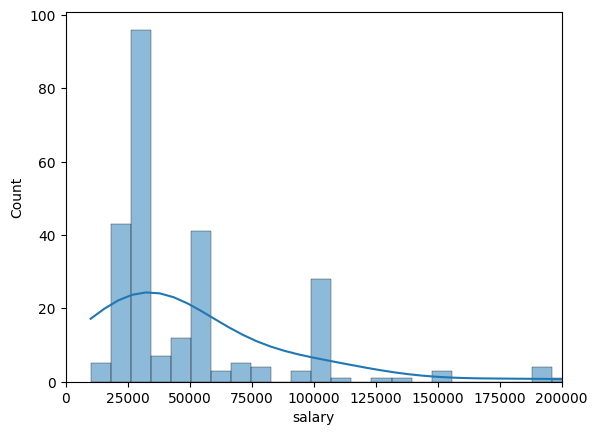

In [335]:
'''Visualización distribución salarios de empleados que se han ido de la empresa.'''
sns.histplot(x= 'salary', data= grupo_variante_rotacion, kde=True)
plt.xlim(0, 200000); 

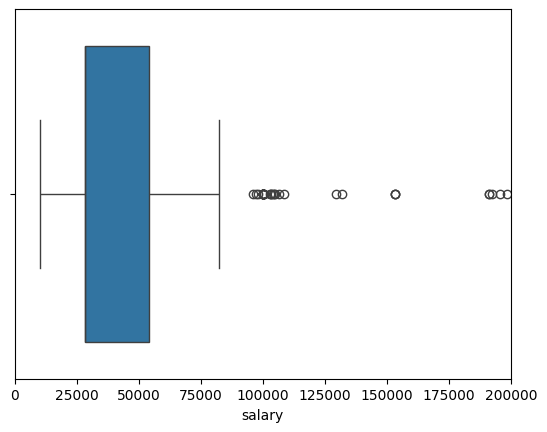

In [336]:
sns.boxplot(x= 'salary', data= grupo_variante_rotacion)
plt.xlim(0, 200000); 

In [ ]:
# Hacemos el test de shapiro para ver si los datos salariales siguen una distribución normal.

def normalidad(dataframe, columna):

    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [338]:
'''¿Siguen los datos salariales de los empleados que siguen en la empresa una distribución normal?'''
normalidad(grupo_control_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [339]:
'''¿Siguen los datos salariales de los empleados que se han ido de la empresa una distribución normal?'''
normalidad(grupo_variante_rotacion, ['salary'])

Para la columna ['salary'] los datos no siguen una distribución normal.


In [ ]:
# los datos no siguen una distribución normal, por tanto, hacemos el test no paramétrico de Man Whitney.

def test_man_whitney(dataframe, metricas, columna_grupos="attrition", grupo_control="No", grupo_variante="Yes"):
    # Verificar si la columna tiene los valores esperados
    grupos = dataframe[columna_grupos].unique()
    if not {grupo_control, grupo_variante}.issubset(grupos):
        raise ValueError(f"La columna '{columna_grupos}' debe contener los valores '{grupo_control}' y '{grupo_variante}'.")

    # Filtrar los datos para los dos grupos
    control = dataframe[dataframe[columna_grupos] == grupo_control]
    variante = dataframe[dataframe[columna_grupos] == grupo_variante]

    # Comprobar que ambos grupos tengan datos suficientes
    if control.empty or variante.empty:
        raise ValueError("Uno de los grupos no tiene datos suficientes para realizar el test.")

    # Realizar el test de Mann-Whitney para cada métrica
    for metrica in metricas:
        if metrica not in dataframe.columns:
            print(f"La métrica '{metrica}' no existe en el DataFrame.")
            continue

        metrica_control = control[metrica]
        metrica_variante = variante[metrica]

        # Aplicar el test de Mann-Whitney
        u_statistic, p_value = stats.mannwhitneyu(metrica_control, metrica_variante)

        # Mostrar los resultados
        if p_value < 0.05:
            print(f"Para la métrica '{metrica}', las medianas son diferentes (p = {p_value:.4f}).")
        else:
            print(f"Para la métrica '{metrica}', las medianas son iguales (p = {p_value:.4f}).")


test_man_whitney(df, ['salary']) 

Para la métrica 'salary', las medianas son diferentes (p = 0.0000).


El test nos indica que podemos rechazar la H0. Es decir, las medianas son significativamente diferentes, por tanto podemos confirmar que el salario influye de manera significativa en la decisión de los empleados de abandonar la empresa.

In [341]:
df_salary = df[['salary', 'attrition']]

In [342]:
df_salary

,salary,attrition
0,195370.00,No
1,199990.00,No
2,192320.00,No
3,171690.00,No
4,153407.04,No
...,...,...
1609,103250.00,Yes
1610,44470.00,No
1611,100071.84,No
1612,53914.11,No


In [343]:
colores = ["#FF007F", "#FF4D6A", "#FF1C45", "#FF0000", "#E50000"]

In [383]:
df_salario = df.groupby('attrition')['salary'].mean().reset_index()

/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/250333469.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attrition', y='salary', data=df_salario, palette=colores)
/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/250333469.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x='attrition', y='salary', data=df_salario, palette=colores)


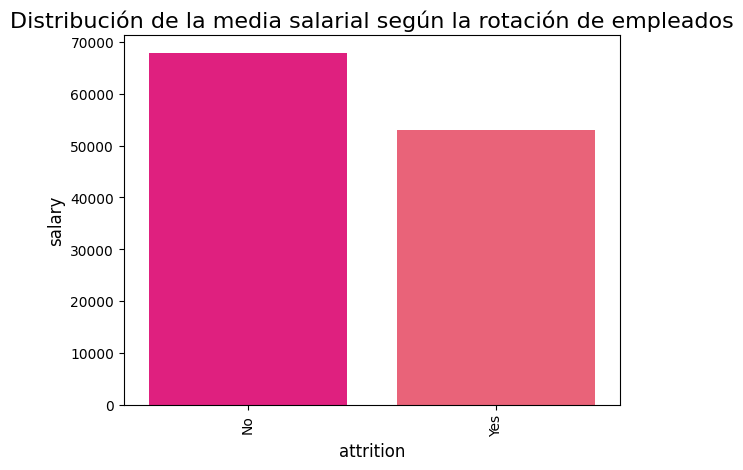

In [384]:
sns.barplot(x='attrition', y='salary', data=df_salario, palette=colores)
plt.title('Distribución de la media salarial según la rotación de empleados', fontsize=16)
plt.xlabel('attrition', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.xticks(rotation=90);

/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/174269663.py:1: UserWarning: The palette list has more values (5) than needed (2), which may not be intended.
  sns.barplot(x='department', y='salary', hue='attrition', data=df_salario_dep, palette=colores)


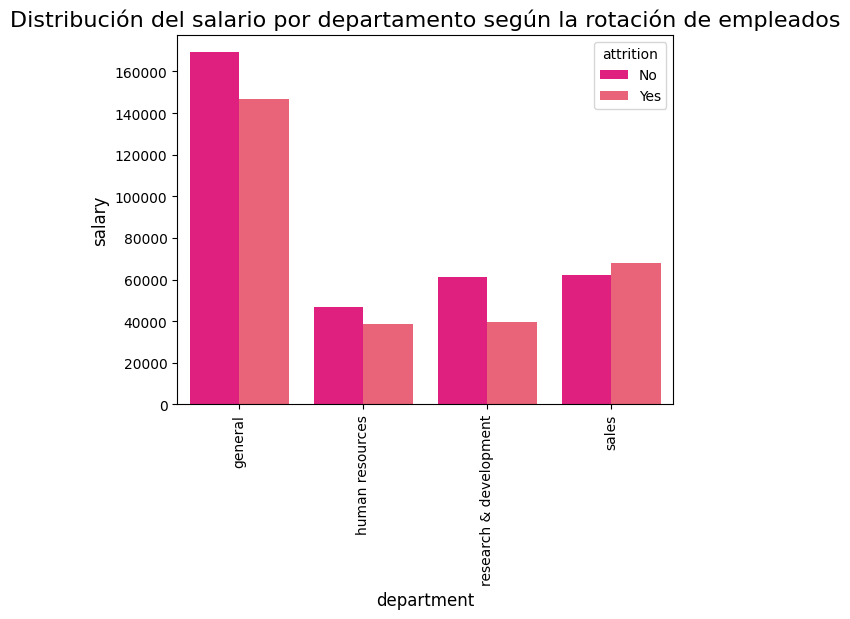

In [ ]:
'''Visualizamos la distribución de salario por departamento. Esta gráfica no la vamos a usar, aunque vemos un dato interesante en el departamento de sales.
Cobran más de media los empleados que se han ido que los que se han quedado. Habría que mirar si las medias de ambos grupos (siguen en la empresa o no) son significativamente
diferentes. Si lo son, recomendar a la empresa que explore otros posibles factores que pueden influir en la rotación de los empleados de este departamento.'''

sns.barplot(x='department', y='salary', hue='attrition', data=df_salario_dep, palette=colores)
plt.title('Distribución del salario por departamento según la rotación de empleados', fontsize=16)
plt.xlabel('department', fontsize=12)
plt.ylabel('salary', fontsize=12)
plt.xticks(rotation=90);

In [ ]:
# Los empleados part-time tienen su salario ajustado a la jornada, por lo que hacemos tests aparte para segurar que no tenga un impacto sobre los datos.

full_time = df[df['standard_hours'] == 'Full Time']

In [349]:
part_time = df[df['standard_hours'] == 'Part Time']

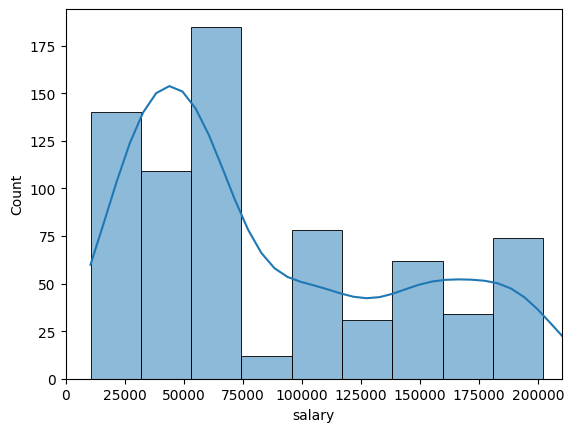

In [350]:
sns.histplot(x= 'salary', data= full_time, kde=True)
plt.xlim(0, 210000); 

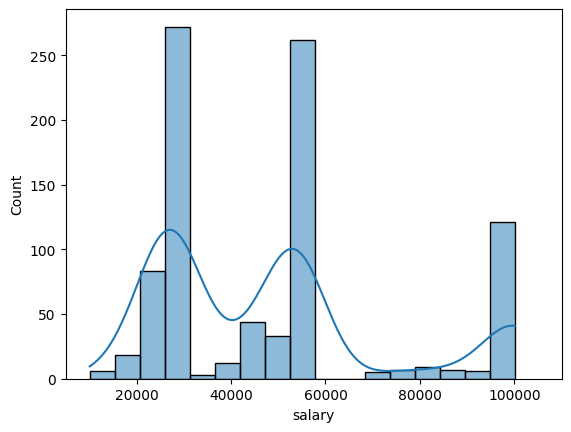

In [351]:
sns.histplot(x= 'salary', data= part_time, kde= True)
plt.xlim(5000, 110000); 

### Hacemos la prueba de M Whitney por separado, ya que no sabemos el equivalente del salario full time para los que trabajan a media jornada y podría afectar sobre cómo están distribuidos los salarios.

In [352]:
# Prueba de Man Whitney para ver la relación entre el salario de los empleados part time y la rotación:

test_man_whitney(part_time, ['salary'], grupo_control='No', grupo_variante='Yes')

Para la métrica 'salary', las medianas son diferentes (p = 0.0000).


### ¿Existe relación entre el nivel de satisfacción del empleado con su worklifebalance y la rotación?

In [353]:
df['work_life_balance'].unique()

array([3., 2., 4., 1.])

In [ ]:
def categorizar_worklife_balance(valor):
    if valor == 1:
        return 'Nada satisfecho'
    elif valor == 2:
        return 'Poco satisfecho'
    elif valor == 3:
        return 'Satisfecho'
    elif valor == 4:
        return 'Muy satisfecho'
    else:
        return 'Desconocido'

# Aplicar la función a la columna
df['work_life_balance_categoria'] = df['work_life_balance'].apply(categorizar_worklife_balance)

df[['work_life_balance', 'work_life_balance_categoria']]

In [ ]:
tabla_contingencia1 = pd.crosstab(df["work_life_balance_categoria"], df["attrition"])
tabla_contingencia1

In [449]:
medias_satisfaction = df.groupby('attrition').agg({'job_satisfaction': 'mean', 'relationship_satisfaction': 'mean', 'work_life_balance': 'mean', 'job_involvement': 'mean'})

In [422]:
df['medias_totales'] = df[['job_satisfaction', 'relationship_satisfaction', 'work_life_balance', 'job_involvement']].mean(axis=1)
resultado = df.groupby('attrition')['medias_totales'].mean()

In [423]:
resultado

attrition
No     2.771218
Yes    2.574324
Name: medias_totales, dtype: float64

In [439]:
grupo_yes = df[df['attrition'] == 'Yes']['medias_totales']

In [440]:
grupo_no = df[df['attrition'] == 'No']['medias_totales']

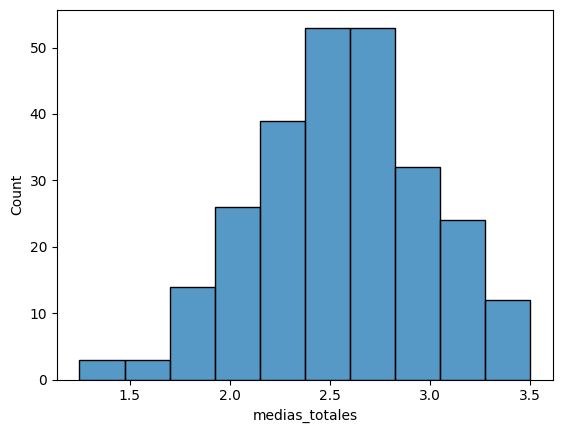

In [435]:
sns.histplot(x='medias_totales', data=grupo_yes);

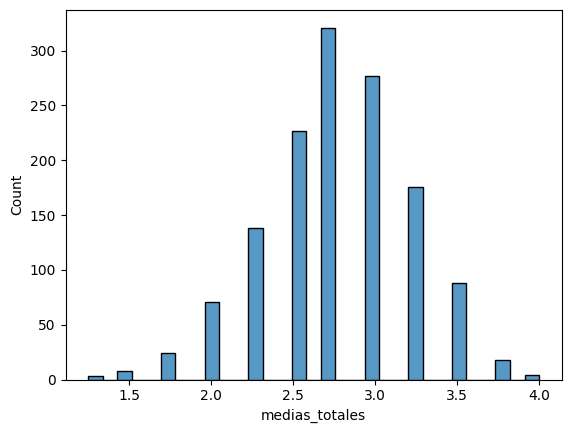

In [436]:
sns.histplot(x='medias_totales', data=grupo_no);

In [432]:
def normalidad(dataframe, columna):

    statistic, p_value = stats.shapiro(dataframe[columna])
    if p_value > 0.05:
        print(f"Para la columna {columna} los datos siguen una distribución normal.")
    else:
        print(f"Para la columna {columna} los datos no siguen una distribución normal.")

In [433]:
normalidad(grupo_yes, 'medias_totales')

Para la columna medias_totales los datos no siguen una distribución normal.


In [434]:
normalidad(grupo_no, 'medias_totales')

Para la columna medias_totales los datos no siguen una distribución normal.


In [441]:
_, p_value = mannwhitneyu(grupo_yes, grupo_no)
print(p_value)

1.379871602492075e-09


In [442]:
p_value<0.05

np.True_

In [450]:
medias_satisfaction

,job_satisfaction,relationship_satisfaction,work_life_balance,job_involvement
attrition,,,,
No,2.786716,2.721771,2.793358,2.783026
Yes,2.486486,2.613900,2.683398,2.513514


In [ ]:
# Crear el gráfico de barras
plot = sns.countplot(x="attrition", data=medias_satisfaction, palette=colores)

# Títulos y etiquetas
plot.set_title("Relación entre nivel de satisfacción general y rotación", fontsize=16)
plot.set_xlabel("Nivel de satisfacción general / Rotación", fontsize=12)
#plt.xticks(ticks=range(1,5))

# Mostrar el gráfico
plt.show();

In [393]:
medias_satisfaction['media_total_satisfaction'] = medias_satisfaction[['job_satisfaction', 'relationship_satisfaction', 'work_life_balance', 'job_involvement']].mean()

In [394]:
medias_satisfaction

,attrition,job_satisfaction,relationship_satisfaction,work_life_balance,job_involvement,media_total_satisfaction
0,No,2.786716,2.721771,2.793358,2.783026,NaN
1,Yes,2.486486,2.613900,2.683398,2.513514,NaN


In [356]:
_, p_value, _, _ = chi2_contingency(tabla_contingencia1)
if p_value <= 0.05:
    print('Existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.')
else:
    print('No existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.')

Existe una relación entre el nivel de satisfacción con el work life balance y la rotación de empleados en la empresa.


El análisis sugiere que, en general, los empleados con menor satisfacción en su balance entre vida y trabajo (por ejemplo, "Nada satisfechos" y "Poco satisfechos") tienen una mayor probabilidad de irse (rotación).

El grupo de empleados "Muy satisfechos" muestra una baja rotación, con mucho más empleados que se quedan.
Los empleados "Nada satisfechos" y "Poco satisfechos" muestran una proporción relativamente alta de rotación, lo que sugiere que la insatisfacción con el balance vida-trabajo está asociada con una mayor probabilidad de abandonar la empresa.

### ¿Hay empleados de departamentos específicos con una rotación significativamente más alta en comparación con el resto?

In [358]:
# Crear la tabla de contingencia entre departamento, rotación y satisfacción
tabla_contingencia2 = pd.crosstab(
    df['department'], df['attrition'])  

tabla_contingencia2


attrition,No,Yes
department,,
general,85,6
human resources,45,13
research & development,860,141
sales,365,99


In [458]:
chi2, p_value, dof, expected = chi2_contingency(tabla_contingencia2)

# Mostrar el resultado
print(f"Valor Chi-cuadrado: {chi2}")
print(f"Valor p: {p_value}")
print(f"Grados de libertad: {dof}")
print(f"Tabla esperada: \n{expected}")

Valor Chi-cuadrado: 20.274820329784614
Valor p: 0.00014887425794656543
Grados de libertad: 3
Tabla esperada: 
[[ 76.39714994  14.60285006]
 [ 48.69268897   9.30731103]
 [840.36864932 160.63135068]
 [389.54151177  74.45848823]]


La relación entre el departamento y la rotación de empleados es estadísticamente significativa. Esto sugiere que los empleados de diferentes departamentos tienen diferentes probabilidades de abandonar la empresa.

Si desearas un análisis más detallado, podrías observar las frecuencias observadas versus las esperadas para ver qué departamentos tienen mayores o menores tasas de rotación de lo que se esperaría si no hubiera ninguna relación.

Por ejemplo, en la tabla esperada, el departamento "research & development" tiene una cantidad significativa de empleados que permanecen (No), mientras que "sales" tiene una mayor cantidad de empleados que se van (Yes), en comparación con las frecuencias esperadas. Esto podría indicar que algunos departamentos tienen una rotación significativamente diferente a la media.

In [454]:
# filtramos empleados de 1 o menos años de antigüedad.

df_menos_1_años = df[(df['years_at_company']<= 1)][['department', 'attrition']]

In [455]:
tabla_porcentajes_filas = pd.crosstab( df_menos_1_años['department'], df_menos_1_años['attrition'], normalize='index') * 100

In [ ]:
tabla_porcentajes_filas #Vemos que en RRHH el 80% de los empleados se fueron antes de cumplir el año de antigüedad.

attrition,No,Yes
department,,
general,100.000000,0.000000
human resources,20.000000,80.000000
research & development,68.027211,31.972789
sales,57.142857,42.857143


In [ ]:
# Hacemos crosstable de los empleados con 1 año o menos de antigüedad por rotación.

cross_departamentos = pd.crosstab(df_menos_1_años['department'], df_menos_1_años['attrition'])

In [ ]:
chi2, p_value, dof, expected = chi2_contingency(cross_departamentos)

# Mostrar el resultado
print(f"Valor Chi-cuadrado: {chi2}")
print(f"Valor p: {p_value}")
print(f"Grados de libertad: {dof}")
print(f"Tabla esperada: \n{expected}")

Valor Chi-cuadrado: 10.346187236799482
Valor p: 0.01584143563019264
Grados de libertad: 3
Tabla esperada: 
[[ 4.55813953  2.44186047]
 [ 3.25581395  1.74418605]
 [95.72093023 51.27906977]
 [36.46511628 19.53488372]]


Interpretación:
El valor Chi-cuadrado de 10.35 junto con un valor p de 0.0158 sugiere que existe una relación significativa entre el departamento y la tasa de rotación (attrition). En otras palabras, los departamentos tienen diferentes patrones de rotación de personal.
Específicamente, en la tabla observada, podemos ver que:
General tiene una tasa de rotación de 0%.
Human Resources tiene una tasa de rotación de 80%, lo que es mucho más alto que en otros departamentos.
Research & Development y Sales tienen tasas de rotación intermedias, pero considerablemente más bajas en comparación con Human Resources.
Dado que el valor p es menor que 0.05, la relación entre el departamento y la tasa de rotación es estadísticamente significativa, lo que sugiere que el departamento al que pertenece un empleado podría influir en su probabilidad de abandonar la empresa.

Para un análisis más detallado, podrías examinar los departamentos con tasas de rotación más altas, como Human Resources, para investigar más a fondo las razones detrás de estos valores.

/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/2168170966.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='proporcion_rotacion', y='department', data=df_department, palette=colores)
/var/folders/n5/d44x7lvd7t5f1m5bfx4hvw7w0000gn/T/ipykernel_12519/2168170966.py:16: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.barplot(x='proporcion_rotacion', y='department', data=df_department, palette=colores)


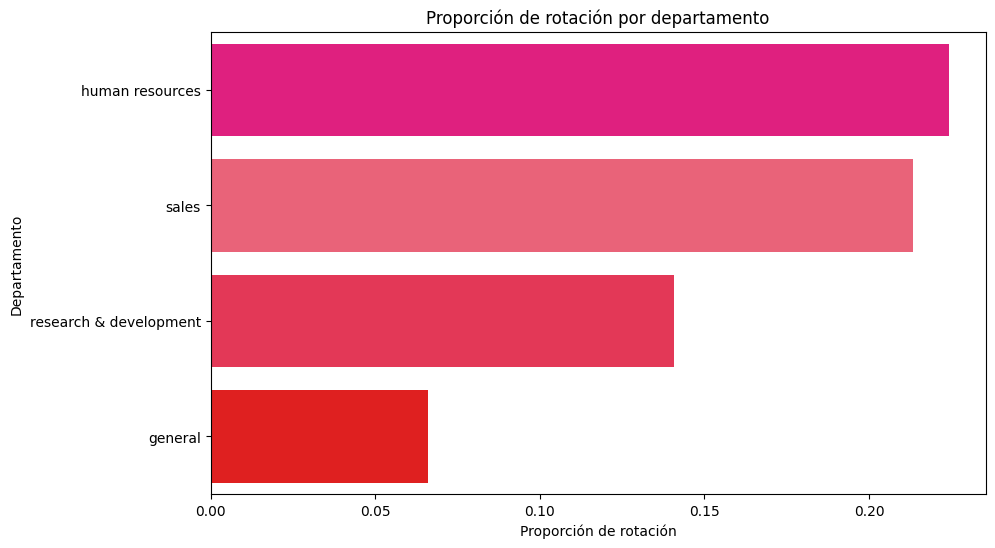

In [ ]:
# Visualización de la proporción de rotación por departamento. 

data = {
    'department': ['general', 'human resources', 'research & development', 'sales'],
    'No': [85, 45, 860, 365],
    'Yes': [6, 13, 141, 99]
}
df_department = pd.DataFrame(data)

# Calcular la proporción de rotación
df_department['proporcion_rotacion'] = df_department['Yes'] / (df_department['No'] + df_department['Yes'])

# Ordenar por proporción de rotación
df_department = df_department.sort_values(by='proporcion_rotacion', ascending=False)

# Graficar
plt.figure(figsize=(10, 6))
sns.barplot(x='proporcion_rotacion', y='department', data=df_department, palette=colores)
plt.title('Proporción de rotación por departamento')
plt.xlabel('Proporción de rotación')
plt.ylabel('Departamento')
plt.show()
